INSTALL ALL LIBRARIES

In [ ]:
!pwd
!wget https://mirrors.estointernet.in/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz

/content
--2020-11-02 16:55:03--  https://mirrors.estointernet.in/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
Resolving mirrors.estointernet.in (mirrors.estointernet.in)... 43.255.166.254, 2403:8940:3:1::f
Connecting to mirrors.estointernet.in (mirrors.estointernet.in)|43.255.166.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219929956 (210M) [application/octet-stream]
Saving to: ‘spark-3.0.1-bin-hadoop2.7.tgz.2’

spark-3.0.1-bin-had 100%[===================>] 209.74M  7.07MB/s    in 54s     

2020-11-02 16:55:58 (3.88 MB/s) - ‘spark-3.0.1-bin-hadoop2.7.tgz.2’ saved [219929956/219929956]



In [ ]:
!tar -xvzf spark-3.0.1-bin-hadoop2.7.tgz

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [ ]:
!ls /content/spark-3.0.1-bin-hadoop2.7

!pip install findspark

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [ ]:
import os 
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
spark =SparkSession.builder.appName("PySpark 3.0 on Google Colab").getOrCreate()

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, Row

In [ ]:
import os
import math
import itertools
import multiprocessing
import pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import OrderedDict
%matplotlib inline
gt0 = time()

In [ ]:
conf = SparkConf()\
    .setMaster(f"local[{multiprocessing.cpu_count()}]")\
    .setAppName("PySpark NSL-KDD")\
    .setAll([("spark.driver.memory", "8g"), ("spark.default.parallelism", f"{multiprocessing.cpu_count()}")])

# Creating local SparkContext with specified SparkConf and creating SQLContext based on it
sc = SparkContext.getOrCreate(conf=conf)
sc.setLogLevel('INFO')
sqlContext = SQLContext(sc)

DATA LOADING

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, split, col
import pyspark.sql.functions as sql
train20_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "/content/KDDTrain+_20Percent.txt")
train_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "/content/KDDTrain+.txt")
test_nsl_kdd_dataset_path = os.path.join("NSL_KDD_Dataset", "/content/KDDTest+.txt")
col_names = np.array(["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels"])

nominal_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 14, 20, 21]
numeric_inx = list(set(range(41)).difference(nominal_inx).difference(binary_inx))

nominal_cols = col_names[nominal_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

In [ ]:
def load_dataset(path):
    dataset_rdd = sc.textFile(path, 8).map(lambda line: line.split(','))
    dataset_df = (dataset_rdd.toDF(col_names.tolist()).select(
                    col('duration').cast(DoubleType()),
                    col('protocol_type').cast(StringType()),
                    col('service').cast(StringType()),
                    col('flag').cast(StringType()),
                    col('src_bytes').cast(DoubleType()),
                    col('dst_bytes').cast(DoubleType()),
                    col('land').cast(DoubleType()),
                    col('wrong_fragment').cast(DoubleType()),
                    col('urgent').cast(DoubleType()),
                    col('hot').cast(DoubleType()),
                    col('num_failed_logins').cast(DoubleType()),
                    col('logged_in').cast(DoubleType()),
                    col('num_compromised').cast(DoubleType()),
                    col('root_shell').cast(DoubleType()),
                    col('su_attempted').cast(DoubleType()),
                    col('num_root').cast(DoubleType()),
                    col('num_file_creations').cast(DoubleType()),
                    col('num_shells').cast(DoubleType()),
                    col('num_access_files').cast(DoubleType()),
                    col('num_outbound_cmds').cast(DoubleType()),
                    col('is_host_login').cast(DoubleType()),
                    col('is_guest_login').cast(DoubleType()),
                    col('count').cast(DoubleType()),
                    col('srv_count').cast(DoubleType()),
                    col('serror_rate').cast(DoubleType()),
                    col('srv_serror_rate').cast(DoubleType()),
                    col('rerror_rate').cast(DoubleType()),
                    col('srv_rerror_rate').cast(DoubleType()),
                    col('same_srv_rate').cast(DoubleType()),
                    col('diff_srv_rate').cast(DoubleType()),
                    col('srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_count').cast(DoubleType()),
                    col('dst_host_srv_count').cast(DoubleType()),
                    col('dst_host_same_srv_rate').cast(DoubleType()),
                    col('dst_host_diff_srv_rate').cast(DoubleType()),
                    col('dst_host_same_src_port_rate').cast(DoubleType()),
                    col('dst_host_srv_diff_host_rate').cast(DoubleType()),
                    col('dst_host_serror_rate').cast(DoubleType()),
                    col('dst_host_srv_serror_rate').cast(DoubleType()),
                    col('dst_host_rerror_rate').cast(DoubleType()),
                    col('dst_host_srv_rerror_rate').cast(DoubleType()),
                    col('labels').cast(StringType())))

    return dataset_df

In [ ]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StringIndexer
from pyspark import keyword_only
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

# Dictionary that contains mapping of various attacks to the four main categories
attack_dict = {
    'normal': 'normal',
    
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

attack_mapping_udf = udf(lambda v: attack_dict[v])

class Labels2Converter(Transformer):

    @keyword_only
    def __init__(self):
        super(Labels2Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels2', sql.regexp_replace(col('labels'), '^(?!normal).*$', 'attack'))
     
class Labels5Converter(Transformer):
    
    @keyword_only
    def __init__(self):
        super(Labels5Converter, self).__init__()

    def _transform(self, dataset):
        return dataset.withColumn('labels5', attack_mapping_udf(col('labels')))
    
labels2_indexer = StringIndexer(inputCol="labels2", outputCol="labels2_index")
labels5_indexer = StringIndexer(inputCol="labels5", outputCol="labels5_index")

labels_mapping_pipeline = Pipeline(stages=[Labels2Converter(), Labels5Converter(), labels2_indexer, labels5_indexer])

labels2 = ['normal', 'attack']
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
labels_col = 'labels2_index'

In [ ]:
# Loading train data
t0 = time()
train_df = load_dataset(train_nsl_kdd_dataset_path)

# Fitting preparation pipeline
labels_mapping_model = labels_mapping_pipeline.fit(train_df)

# Transforming labels column and adding id column
train_df = labels_mapping_model.transform(train_df).withColumn('id', sql.monotonically_increasing_id())

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in train set: 125973
Time: 13.39s


In [ ]:
# Loading test data
t0 = time()
test_df = load_dataset(test_nsl_kdd_dataset_path)

# Transforming labels column and adding id column
test_df = labels_mapping_model.transform(test_df).withColumn('id', sql.monotonically_increasing_id())

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 2.62s


EXPLORATORY DATA ANALYSIS

In [ ]:
# Labels columns
(train_df.groupby('labels2').count().show())
(train_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal|67343|
| attack|58630|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal|67343|
|    DoS|45927|
|  Probe|11656|
|    R2L|  995|
|    U2R|   52|
+-------+-----+



In [ ]:
(test_df.groupby('labels2').count().show())
(test_df.groupby('labels5').count().sort(sql.desc('count')).show())

+-------+-----+
|labels2|count|
+-------+-----+
| normal| 9711|
| attack|12833|
+-------+-----+

+-------+-----+
|labels5|count|
+-------+-----+
| normal| 9711|
|    DoS| 7458|
|    R2L| 2754|
|  Probe| 2421|
|    U2R|  200|
+-------+-----+



In [ ]:
# 'protocol_type' nominal column
(train_df.crosstab(nominal_cols[0], 'labels2').sort(sql.asc(nominal_cols[0] + '_labels2')).show())
(train_df.crosstab(nominal_cols[0], 'labels5').sort(sql.asc(nominal_cols[0] + '_labels5')).show())

+---------------------+------+------+
|protocol_type_labels2|attack|normal|
+---------------------+------+------+
|                 icmp|  6982|  1309|
|                  tcp| 49089| 53600|
|                  udp|  2559| 12434|
+---------------------+------+------+

+---------------------+-----+-----+---+---+------+
|protocol_type_labels5|  DoS|Probe|R2L|U2R|normal|
+---------------------+-----+-----+---+---+------+
|                 icmp| 2847| 4135|  0|  0|  1309|
|                  tcp|42188| 5857|995| 49| 53600|
|                  udp|  892| 1664|  0|  3| 12434|
+---------------------+-----+-----+---+---+------+



In [ ]:
# 'service' nominal column
print(train_df.select(nominal_cols[1]).distinct().count())
(train_df.crosstab(nominal_cols[1], 'labels2').sort(sql.asc(nominal_cols[1] + '_labels2')).show(n=70))
(train_df.crosstab(nominal_cols[1], 'labels5').sort(sql.asc(nominal_cols[1] + '_labels5')).show(n=70))

70
+---------------+------+------+
|service_labels2|attack|normal|
+---------------+------+------+
|            IRC|     1|   186|
|            X11|     6|    67|
|         Z39_50|   862|     0|
|            aol|     2|     0|
|           auth|   719|   236|
|            bgp|   710|     0|
|        courier|   734|     0|
|       csnet_ns|   545|     0|
|            ctf|   563|     0|
|        daytime|   521|     0|
|        discard|   538|     0|
|         domain|   531|    38|
|       domain_u|     9|  9034|
|           echo|   434|     0|
|          eco_i|  4089|   497|
|          ecr_i|  2887|   190|
|            efs|   485|     0|
|           exec|   474|     0|
|         finger|  1222|   545|
|            ftp|   836|   918|
|       ftp_data|  1876|  4984|
|         gopher|   518|     0|
|        harvest|     2|     0|
|      hostnames|   460|     0|
|           http|  2289| 38049|
|      http_2784|     1|     0|
|       http_443|   530|     0|
|      http_8001|     2|     0|
|    

In [ ]:
# 'flag' nominal column
print(train_df.select(nominal_cols[2]).distinct().count())
(train_df.crosstab(nominal_cols[2], 'labels2').sort(sql.asc(nominal_cols[2] + '_labels2')).show())
(train_df.crosstab(nominal_cols[2], 'labels5').sort(sql.asc(nominal_cols[2] + '_labels5')).show())

11
+------------+------+------+
|flag_labels2|attack|normal|
+------------+------+------+
|         OTH|    35|    11|
|         REJ|  8540|  2693|
|        RSTO|  1343|   219|
|      RSTOS0|   103|     0|
|        RSTR|  2275|   146|
|          S0| 34497|   354|
|          S1|     4|   361|
|          S2|     8|   119|
|          S3|     4|    45|
|          SF| 11552| 63393|
|          SH|   269|     2|
+------------+------+------+

+------------+-----+-----+---+---+------+
|flag_labels5|  DoS|Probe|R2L|U2R|normal|
+------------+-----+-----+---+---+------+
|         OTH|    0|   35|  0|  0|    11|
|         REJ| 5671| 2869|  0|  0|  2693|
|        RSTO| 1216|   80| 46|  1|   219|
|      RSTOS0|    0|  103|  0|  0|     0|
|        RSTR|   90| 2180|  5|  0|   146|
|          S0|34344|  153|  0|  0|   354|
|          S1|    2|    1|  1|  0|   361|
|          S2|    5|    2|  1|  0|   119|
|          S3|    0|    1|  3|  0|    45|
|          SF| 4599| 5967|935| 51| 63393|
|          SH| 

In [ ]:
# Binary columns
(train_df.select(binary_cols).describe().toPandas().transpose())

,0,1,2,3,4
summary,count,mean,stddev,min,max
land,125973,1.9845522453224102E-4,0.014086071671513094,0.0,1.0
logged_in,125973,0.3957355941352512,0.48901005300524175,0.0,1.0
root_shell,125973,0.0013415573178379495,0.03660284383979861,0.0,1.0
su_attempted,125973,0.0011034110483992602,0.04515438381386557,0.0,2.0
is_host_login,125973,7.938208981289641E-6,0.0028174827384191085,0.0,1.0
is_guest_login,125973,0.009422654060790804,0.09661232709143104,0.0,1.0


In [ ]:
# 'su_attempted' should be a binary feature, but has 3 values
(train_df.crosstab('su_attempted', 'labels2').show())

+--------------------+------+------+
|su_attempted_labels2|attack|normal|
+--------------------+------+------+
|                 2.0|     0|    59|
|                 1.0|     1|    20|
|                 0.0| 58629| 67264|
+--------------------+------+------+



In [ ]:
# '2.0' value is replaced to '0.0' for both train and test datasets
train_df = train_df.replace(2.0, 0.0, 'su_attempted')
test_df = test_df.replace(2.0, 0.0, 'su_attempted')

In [ ]:
# Numeric columns
print(len(numeric_cols))
(train_df.select(numeric_cols).describe().toPandas().transpose())

32


,0,1,2,3,4
summary,count,mean,stddev,min,max
duration,125973,287.1446500440571,2604.515309867592,0.0,42908.0
src_bytes,125973,45566.74300048423,5870331.181893551,0.0,1.379963888E9
dst_bytes,125973,19779.114421344257,4021269.1514414474,0.0,1.309937401E9
wrong_fragment,125973,0.022687401268525795,0.25352998595201254,0.0,3.0
urgent,125973,1.1113492573805498E-4,0.014366026620154243,0.0,3.0
hot,125973,0.20440888126820828,2.1499684337047587,0.0,77.0
num_failed_logins,125973,0.0012224841831186047,0.045239138981329835,0.0,5.0
num_compromised,125973,0.279250315543807,23.942042242795125,0.0,7479.0
num_root,125973,0.30219173949973405,24.3996180888374,0.0,7468.0


In [ ]:
(train_df.crosstab('num_outbound_cmds', 'labels2').show())

+-------------------------+------+------+
|num_outbound_cmds_labels2|attack|normal|
+-------------------------+------+------+
|                      0.0| 58630| 67343|
+-------------------------+------+------+



In [ ]:
train_df = train_df.drop('num_outbound_cmds')
test_df = test_df.drop('num_outbound_cmds')
numeric_cols.remove('num_outbound_cmds')

HOT ENCODING

One Hot Encoding (OHE) is used for treating categorical variables. Custom function is created for demonstration purposes. However, it could be easily replaced by PySpark OneHotEncoder.

In [ ]:
def ohe_vec(cat_dict, row):
    vec = np.zeros(len(cat_dict))
    vec[cat_dict[row]] = float(1.0)
    return vec.tolist()

def ohe(df, nominal_col):
    categories = (df.select(nominal_col)
                    .distinct()
                    .rdd.map(lambda row: row[0])
                    .collect())
    
    cat_dict = dict(zip(categories, range(len(categories))))
    
    udf_ohe_vec = udf(lambda row: ohe_vec(cat_dict, row), 
                      StructType([StructField(cat, DoubleType(), False) for cat in categories]))
    
    df = df.withColumn(nominal_col + '_ohe', udf_ohe_vec(col(nominal_col))).cache()
    
    nested_cols = [nominal_col + '_ohe.' + cat for cat in categories]
    ohe_cols = [nominal_col + '_' + cat for cat in categories]
        
    for new, old in zip(ohe_cols, nested_cols):
        df = df.withColumn(new, col(old))

    df = df.drop(nominal_col + '_ohe')
                   
    return df, ohe_cols

In [ ]:
t0 = time()
train_ohe_cols = []

train_df, train_ohe_col0 = ohe(train_df, nominal_cols[0])
train_ohe_cols += train_ohe_col0

train_df, train_ohe_col1 = ohe(train_df, nominal_cols[1])
train_ohe_cols += train_ohe_col1

train_df, train_ohe_col2 = ohe(train_df, nominal_cols[2])
train_ohe_cols += train_ohe_col2

binary_cols += train_ohe_cols

train_df = train_df.cache()
print(f"Number of examples in train set: {train_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in train set: 125973
Time: 51.87s


In [ ]:
t0 = time()
test_ohe_cols = []

test_df, test_ohe_col0_names = ohe(test_df, nominal_cols[0])
test_ohe_cols += test_ohe_col0_names

test_df, test_ohe_col1_names = ohe(test_df, nominal_cols[1])
test_ohe_cols += test_ohe_col1_names

test_df, test_ohe_col2_names = ohe(test_df, nominal_cols[2])
test_ohe_cols += test_ohe_col2_names

test_binary_cols = col_names[binary_inx].tolist() + test_ohe_cols

test_df = test_df.cache()
print(f"Number of examples in test set: {test_df.count()}")
print(f"Time: {time() - t0:.2f}s")

Number of examples in test set: 22544
Time: 30.77s


FEATURE SELECTION

As it is a possible to have 'null' values because binary features could have Frequency(0) = 0, those 'null' values are replaced with 1000.0 (magic number). For NSL KDD dataset it is related only for 'protocol_type_tcp' ohe variable.

In [ ]:
def getAttributeRatio(df, numericCols, binaryCols, labelCol):
    ratio_dict = {}
    
    if numericCols:
        avg_dict = (df
                .select(list(map(lambda c: sql.avg(c).alias(c), numericCols)))
                .first()
                .asDict())

        ratio_dict.update(df
                .groupBy(labelCol)
                .avg(*numericCols)
                .select(list(map(lambda c: sql.max(col('avg(' + c + ')')/avg_dict[c]).alias(c), numericCols)))
                .fillna(0.0)
                .first()
                .asDict())
    
    if binaryCols:
        ratio_dict.update((df
                .groupBy(labelCol)
                .agg(*list(map(lambda c: (sql.sum(col(c))/(sql.count(col(c)) - sql.sum(col(c)))).alias(c), binaryCols)))
                .fillna(1000.0)
                .select(*list(map(lambda c: sql.max(col(c)).alias(c), binaryCols)))
                .first()
                .asDict()))
        
    return OrderedDict(sorted(ratio_dict.items(), key=lambda v: -v[1]))

def selectFeaturesByAR(ar_dict, min_ar):
    return [f for f in ar_dict.keys() if ar_dict[f] >= min_ar]

In [ ]:
t0 = time()
ar_dict = getAttributeRatio(train_df, numeric_cols, binary_cols, 'labels5')

print(f"Number of features in Attribute Ration dict: {len(ar_dict)}")
print(f"Time: {time() - t0:.2f}s")
ar_dict

Number of features in Attribute Ration dict: 121
Time: 23.34s


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 326.11353550295854),
             ('urgent', 173.03983516483518),
             ('num_file_creations', 62.23362492770388),
             ('flag_SF', 51.0),
             ('num_failed_logins', 46.03855641845592),
             ('hot', 40.77451681709518),
             ('logged_in', 10.569767441860465),
             ('dst_bytes', 9.154854355343401),
             ('src_bytes', 8.464064204948945),
             ('duration', 7.225829157212557),
             ('dst_host_srv_diff_host_rate', 5.756880682756574),
             ('dst_host_diff_srv_rate', 4.83734184897426),
             ('num_access_files', 4.694879248658319),
             ('dst_host_same_src_port_rate', 4.393080378884017),
             ('num_compromised', 4.338539274983927),
             ('diff_srv_rate', 4.069085485070395),
             ('dst_host_srv_rerror_rate', 3.667920527965924),
             ('srv_rerror_rate', 3.667741802325429),
             ('rerror_rate',

DATA PREPARATION

Standartization is necessary as a lot of distance based algorithms are used below. Custom standartization is created for demonstration purposes, so it could be easily replaced by PySpark StandardScaler. Note that data is sparse, so it is reasonable to not substract mean for avoiding violating sparsity.

In [ ]:
t0 = time()
avg_dict = (train_df.select(list(map(lambda c: sql.avg(c).alias(c), numeric_cols))).first().asDict())
std_dict = (train_df.select(list(map(lambda c: sql.stddev(c).alias(c), numeric_cols))).first().asDict())

def standardizer(column):
    return ((col(column) - avg_dict[column])/std_dict[column]).alias(column)

# Standardizer without mean
# def standardizer(column):
#     return (col(column)/std_dict[column]).alias(column)

train_scaler = [*binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]
test_scaler = [*test_binary_cols, *list(map(standardizer, numeric_cols)), *['id', 'labels2_index', 'labels2', 'labels5_index', 'labels5']]

scaled_train_df = (train_df.select(train_scaler).cache())
scaled_test_df = (test_df.select(test_scaler).cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 10.54s


In [ ]:
from pyspark.ml.feature import VectorIndexer, VectorAssembler
assembler = VectorAssembler(inputCols=selectFeaturesByAR(ar_dict, 0.01), outputCol='raw_features')
indexer = VectorIndexer(inputCol='raw_features', outputCol='indexed_features', maxCategories=2)

prep_pipeline = Pipeline(stages=[assembler, indexer])
prep_model = prep_pipeline.fit(scaled_train_df)

In [ ]:
t0 = time()
scaled_train_df = (prep_model
        .transform(scaled_train_df)
        .select('id', 'indexed_features', 'labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

scaled_test_df = (prep_model 
        .transform(scaled_test_df)
        .select('id', 'indexed_features','labels2_index', 'labels2', 'labels5_index', 'labels5')
        .cache())

print(scaled_train_df.count())
print(scaled_test_df.count())
print(f"Time: {time() - t0:.2f}s")

125973
22544
Time: 6.78s


In [ ]:
# Setting seed for reproducibility
seed = 4667979835606274383
print(seed)

4667979835606274383


In [ ]:
split = (scaled_train_df.randomSplit([0.8, 0.2], seed=seed))

scaled_train_df = split[0].cache()
scaled_cv_df = split[1].cache()

print(scaled_train_df.count())
print(scaled_cv_df.count())

100828
25145


In [ ]:
res_cv_df = scaled_cv_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
res_test_df = scaled_test_df.select(col('id'), col('labels2_index'), col('labels2'), col('labels5')).cache()
prob_cols = []
pred_cols = []

print(res_cv_df.count())
print(res_test_df.count())

25145
22544




Different metrics from sklearn are used for evaluating results. The most important from them for this task are False positive Rate, Detection Rate and F1 score. As evaluating via sklearn requires to collect predicted and label columns to the driver, it will be replaced with PySpark metrics later.


In [ ]:
import sklearn.metrics as metrics

def printCM(cm, labels):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels])
    # Print header
    print(" " * columnwidth, end="\t")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end="\t")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("%{0}s".format(columnwidth) % label1, end="\t")
        for j in range(len(labels)):
            print("%{0}d".format(columnwidth) % cm[i, j], end="\t")
        print()

def getPrediction(e):
    return udf(lambda row: 1.0 if row >= e else 0.0, DoubleType())
        
def printReport(resDF, probCol, labelCol='labels2_index', e=None, labels=['normal', 'attack']):
    if (e):
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (1.0 if row[probCol] >= e else 0.0, row[labelCol]))
                                       .collect()))
    else:
        predictionAndLabels = list(zip(*resDF.rdd
                                       .map(lambda row: (row[probCol], row[labelCol]))
                                       .collect()))
    
    cm = metrics.confusion_matrix(predictionAndLabels[1], predictionAndLabels[0])
    printCM(cm, labels)
    print(" ")
    print("Accuracy = %g" % (metrics.accuracy_score(predictionAndLabels[1], predictionAndLabels[0])))
    print("AUC = %g" % (metrics.roc_auc_score(predictionAndLabels[1], predictionAndLabels[0])))
    print(" ")
    print("False Alarm Rate = %g" % (cm[0][1]/(cm[0][0] + cm[0][1])))
    print("Detection Rate = %g" % (cm[1][1]/(cm[1][1] + cm[1][0])))
    print("F1 score = %g" % (metrics.f1_score(predictionAndLabels[1], predictionAndLabels[0], labels)))
    print(" ")
    print(metrics.classification_report(predictionAndLabels[1], predictionAndLabels[0]))
    print(" ")

VISUALIZATION WITH PCA



PCA algorithm is used for visualization purposes. It's also used later as preprocessing for Gaussian Mixture clustering.

First graph shows 'attack' vs 'normal' labels, second graph shows 4 different types of attacks vs normal connections.


In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import PCA

t0 = time()
pca_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", names=selectFeaturesByAR(ar_dict, 0.05))

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_pipeline = Pipeline(stages=[pca_slicer, pca])

pca_train_df = pca_pipeline.fit(scaled_train_df).transform(scaled_train_df)
print(f"Time: {time() - t0:.2f}s")

Time: 7.00s


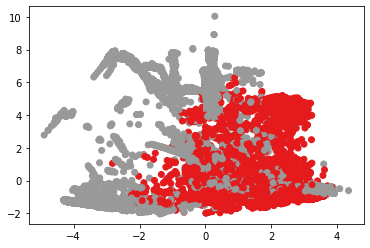

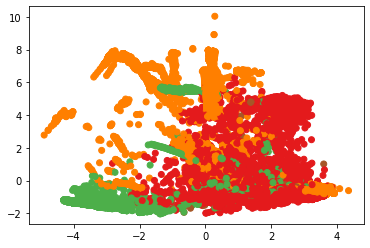

25.287659883499146


In [ ]:
t0 = time()
viz_train_data = np.array(pca_train_df.rdd.map(lambda row: [*row['pca_features'], row['labels2_index'], row['labels5_index']]).collect())
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,2], cmap="Set1")
plt.figure()
plt.scatter(x=viz_train_data[:,0], y=viz_train_data[:,1], c=viz_train_data[:,3], cmap="Set1")
plt.show()
print(time() - t0)

KMEANS CLUSTERING WITH RANDOM FOREST CLASSIFIER



The idea of the first approach is to clusterize data into clusters and then train different Random Forest classifiers for each of the clusters. As Random Forest returns probabilities, it is possible to improve detection rate for a new types of attacks by adjusting threshold.

As KMeans cannot truly handle binary/categorical features only numeric features are used for clustarization.


In [ ]:
kmeans_prob_col = 'kmeans_rf_prob'
kmeans_pred_col = 'kmeans_rf_pred'

prob_cols.append(kmeans_prob_col)
pred_cols.append(kmeans_pred_col)

In [ ]:
# KMeans clustrering
from pyspark.ml.clustering import KMeans

t0 = time()
kmeans_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                             names=list(set(selectFeaturesByAR(ar_dict, 0.1)).intersection(numeric_cols)))

kmeans = KMeans(k=8, initSteps=25, maxIter=100, featuresCol="features", predictionCol="cluster", seed=seed)

kmeans_pipeline = Pipeline(stages=[kmeans_slicer, kmeans])

kmeans_model = kmeans_pipeline.fit(scaled_train_df)

kmeans_train_df = kmeans_model.transform(scaled_train_df).cache()
kmeans_cv_df = kmeans_model.transform(scaled_cv_df).cache()
kmeans_test_df = kmeans_model.transform(scaled_test_df).cache()

print(f"Time: {time() - t0:.2f}s")

Time: 32.77s


In [ ]:
# Function for describing the contents of the clusters 
def getClusterCrosstab(df, clusterCol='cluster'):
    return (df.crosstab(clusterCol, 'labels2')
              .withColumn('count', col('attack') + col('normal'))
              .withColumn(clusterCol + '_labels2', col(clusterCol + '_labels2').cast('int'))
              .sort(col(clusterCol +'_labels2').asc()))
kmeans_crosstab = getClusterCrosstab(kmeans_train_df).cache()
kmeans_crosstab.show(n=30)    

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0| 27748|    95|27843|
|              1|     4|    18|   22|
|              2|  5813| 50767|56580|
|              3|  7067|  2270| 9337|
|              4|  3460|   491| 3951|
|              5|   628|   137|  765|
|              6|     0|     1|    1|
|              7|  2169|   160| 2329|
+---------------+------+------+-----+



Clustres are splitted into two categories. Frist category contains clusters that have both 'attack' and 'normal' connections and have more than 25 connections. For the first category Random Forest classifiers are aplied. Second category contains all other clusters and maps cluster to 'attack' or 'normal' based on majority. All clusters that contains less or equal than 25 connections are treated as outliers and are mapped to 'attack' type.

In [ ]:
# Function for splitting clusters
def splitClusters(crosstab):
    exp = ((col('count') > 25) & (col('attack') > 0) & (col('normal') > 0))

    cluster_rf = (crosstab
        .filter(exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), [row['count'], row['attack']/row['count']]))
        .collectAsMap())

    cluster_mapping = (crosstab
        .filter(~exp).rdd
        .map(lambda row: (int(row['cluster_labels2']), 1.0 if (row['count'] <= 25) | (row['normal'] == 0) else 0.0))
        .collectAsMap())
    
    return cluster_rf, cluster_mapping

kmeans_cluster_rf, kmeans_cluster_mapping = splitClusters(kmeans_crosstab)

print(len(kmeans_cluster_rf), len(kmeans_cluster_mapping))
print(kmeans_cluster_mapping)
kmeans_cluster_rf

6 2
{1: 1.0, 6: 1.0}


{0: [27843, 0.9965880113493517],
 2: [56580, 0.10273948391657829],
 3: [9337, 0.7568812252329442],
 4: [3951, 0.8757276638825614],
 5: [765, 0.8209150326797385],
 7: [2329, 0.931300987548304]}

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# This function returns Random Forest models for provided clusters
def getClusterModels(df, cluster_rf):
    cluster_models = {}

    labels_col = 'labels2_cl_index'
    labels2_indexer.setOutputCol(labels_col)

    rf_slicer = VectorSlicer(inputCol="indexed_features", outputCol="rf_features", 
                             names=selectFeaturesByAR(ar_dict, 0.05))

    for cluster in cluster_rf.keys():
        t1 = time()
        rf_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                               numTrees=500, maxDepth=20, featureSubsetStrategy="sqrt")
        
        rf_pipeline = Pipeline(stages=[labels2_indexer, rf_slicer, rf_classifier])
        cluster_models[cluster] = rf_pipeline.fit(df.filter(col('cluster') == cluster))
        print("Finished %g cluster in %g s" % (cluster, time() - t1))
        
    return cluster_models

In [ ]:
# This utility function helps to get predictions/probabilities for the new data and return them into one dataframe
def getProbabilities(df, probCol, cluster_mapping, cluster_models):
    pred_df = (sqlContext.createDataFrame([], StructType([
                    StructField('id', LongType(), False),
                    StructField(probCol, DoubleType(), False)])))
    
    udf_map = udf(lambda cluster: cluster_mapping[cluster], DoubleType())
    pred_df = pred_df.union(df.filter(col('cluster').isin(list(cluster_mapping.keys())))
                            .withColumn(probCol, udf_map(col('cluster')))
                            .select('id', probCol))

                                       
    for k in cluster_models.keys():
        maj_label = cluster_models[k].stages[0].labels[0]
        udf_remap_prob = udf(lambda row: float(row[0]) if (maj_label == 'attack') else float(row[1]), DoubleType())

        pred_df = pred_df.union(cluster_models[k]
                         .transform(df.filter(col('cluster') == k))
                         .withColumn(probCol, udf_remap_prob(col('probability')))
                         .select('id', probCol))

    return pred_df

In [ ]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
kmeans_cluster_models = getClusterModels(kmeans_train_df, kmeans_cluster_rf)
print(f"Time: {time() - t0:.2f}s")

Finished 0 cluster in 57.5679 s
Finished 2 cluster in 698.448 s
Finished 3 cluster in 67.315 s
Finished 4 cluster in 37.1528 s
Finished 5 cluster in 8.87204 s
Finished 7 cluster in 16.1184 s
Time: 885.49s


In [ ]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(kmeans_prob_col)
             .join(getProbabilities(kmeans_cv_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 113.70s


In [ ]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(kmeans_prob_col)
               .join(getProbabilities(kmeans_test_df, kmeans_prob_col, kmeans_cluster_mapping, kmeans_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 112.22s


In [ ]:
printReport(res_cv_df, kmeans_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 13393	    11	
attack	    20	 11721	
 
Accuracy = 0.998767
AUC = 0.998738
 
False Alarm Rate = 0.000820651
Detection Rate = 0.998297
F1 score = 0.998679
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13404
         1.0       1.00      1.00      1.00     11741

    accuracy                           1.00     25145
   macro avg       1.00      1.00      1.00     25145
weighted avg       1.00      1.00      1.00     25145

 


Because test data is from the different distribution and it is expected to face unseen attack types, it makes sence to adjust a probability threshold to something like 0.01 for attack connections (0.99 for normal connections). For this approach it gives around ~98-99% Detection Rate with around ~14-15% of False Alarm Rate.

In [ ]:
printReport(res_test_df, kmeans_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8191	  1520	
attack	    79	 12754	
 
Accuracy = 0.929072
AUC = 0.91866
 
False Alarm Rate = 0.156524
Detection Rate = 0.993844
F1 score = 0.941012
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.93     22544
weighted avg       0.94      0.93      0.93     22544

 


In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(kmeans_pred_col, getPrediction(0.5)(col(kmeans_prob_col))).cache()
res_test_df = res_test_df.withColumn(kmeans_pred_col, getPrediction(0.01)(col(kmeans_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 211.35s


Gaussian Mixture clustering with Random Forest Classifiers


The idea of this approach is to clusterize data into clusters via Gaussian Mixture and then train different Random Forest classifiers for each of the clusters. Gaussian Mixture produces a diffirent clustering than KMeans, so results from both approaches could be combine for improving performance. As Gaussian Mixture clustering doesn't work well on high-demensional data PCA algorithm is used for preprocessing.

In [ ]:
gm_prob_col = 'gm_rf_prob'
gm_pred_col = 'gm_rf_pred'

prob_cols.append(gm_prob_col)
pred_cols.append(gm_pred_col)

In [ ]:
# Gaussian Mixture clustering
from pyspark.ml.clustering import GaussianMixture

t0 = time()
gm = GaussianMixture(k=8, maxIter=150, seed=seed, featuresCol="pca_features", 
                     predictionCol="cluster", probabilityCol="gm_prob")

gm_pipeline = Pipeline(stages=[pca_slicer, pca, gm])
gm_model = gm_pipeline.fit(scaled_train_df)

gm_train_df = gm_model.transform(scaled_train_df).cache()
gm_cv_df = gm_model.transform(scaled_cv_df).cache()
gm_test_df = gm_model.transform(scaled_test_df).cache()

gm_params = (gm_model.stages[2].gaussiansDF.rdd
                  .map(lambda row: [row['mean'].toArray(), row['cov'].toArray()])
                  .collect())
gm_weights = gm_model.stages[2].weights

print(gm_train_df.count())
print(gm_cv_df.count())
print(gm_test_df.count())
print(f"Time: {time() - t0:.2f}s")

100828
25145
22544
Time: 75.81s


In [ ]:
# Description of the contents of the clusters 
gm_crosstab = getClusterCrosstab(gm_train_df).cache()
gm_crosstab.show(n=30)

+---------------+------+------+-----+
|cluster_labels2|attack|normal|count|
+---------------+------+------+-----+
|              0|  3953|  4160| 8113|
|              1|  2194|  5977| 8171|
|              2|    10| 26068|26078|
|              3|  3228| 15366|18594|
|              4|  3907|     0| 3907|
|              5|   927|    84| 1011|
|              6| 22864|     0|22864|
|              7|  9806|  2284|12090|
+---------------+------+------+-----+



In [ ]:
# Splitting clusters
gm_cluster_rf, gm_cluster_mapping = splitClusters(gm_crosstab)

print(len(gm_cluster_rf), len(gm_cluster_mapping))
print(gm_cluster_mapping)
gm_cluster_rf

6 2
{4: 1.0, 6: 1.0}


{0: [8113, 0.4872426969061999],
 1: [8171, 0.268510586219557],
 2: [26078, 0.0003834649896464453],
 3: [18594, 0.17360438851242335],
 5: [1011, 0.9169139465875371],
 7: [12090, 0.8110835401157982]}

In [ ]:
# Training Random Forest classifiers for each of the clusters
t0 = time()
gm_cluster_models = getClusterModels(gm_train_df, gm_cluster_rf)
print(f"Time: {time() - t0:.2f}s")

Finished 0 cluster in 110.298 s
Finished 1 cluster in 207.022 s
Finished 2 cluster in 34.4438 s
Finished 3 cluster in 227.027 s
Finished 5 cluster in 17.9328 s
Finished 7 cluster in 92.6601 s
Time: 689.39s


In [ ]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(gm_prob_col)
             .join(getProbabilities(gm_cv_df, gm_prob_col, gm_cluster_mapping, gm_cluster_models), 'id')
             .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 270.15s


In [ ]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(gm_prob_col)
               .join(getProbabilities(gm_test_df, gm_prob_col, gm_cluster_mapping, gm_cluster_models), 'id')
               .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 270.68s


In [ ]:
printReport(res_cv_df, gm_prob_col, e=0.5, labels=labels2)

      	normal	attack	
normal	 13395	     9	
attack	    25	 11716	
 
Accuracy = 0.998648
AUC = 0.9986
 
False Alarm Rate = 0.000671441
Detection Rate = 0.997871
F1 score = 0.998551
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13404
         1.0       1.00      1.00      1.00     11741

    accuracy                           1.00     25145
   macro avg       1.00      1.00      1.00     25145
weighted avg       1.00      1.00      1.00     25145

 


In [ ]:
printReport(res_test_df, gm_prob_col, e=0.01, labels=labels2)

      	normal	attack	
normal	  8311	  1400	
attack	   321	 12512	
 
Accuracy = 0.92366
AUC = 0.91541
 
False Alarm Rate = 0.144166
Detection Rate = 0.974986
F1 score = 0.935652
 
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91      9711
         1.0       0.90      0.97      0.94     12833

    accuracy                           0.92     22544
   macro avg       0.93      0.92      0.92     22544
weighted avg       0.93      0.92      0.92     22544

 


In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(gm_pred_col, getPrediction(0.5)(col(gm_prob_col))).cache()
res_test_df = res_test_df.withColumn(gm_pred_col, getPrediction(0.01)(col(gm_prob_col))).cache()

print(res_cv_df.count())

#print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 159.83s


Supervised approach for dettecting each type of attacks separately

The idea of the following approach is training Random Forest Classifiers for each of four major 'attack' categories separately.


DoS and normal

In [ ]:
dos_prob_col = 'dos_prob'
dos_pred_col = 'dos_pred'

prob_cols.append(dos_prob_col)
pred_cols.append(dos_pred_col)

In [ ]:
dos_exp = (col('labels5') == 'DoS') | (col('labels5') == 'normal')
dos_train_df = (scaled_train_df.filter(dos_exp).cache())

print(dos_train_df.count())
(dos_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

90661
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53939|
|    DoS|36722|
+-------+-----+



In [ ]:
t0 = time()
dos_ar_dict = getAttributeRatio(train_df.filter(dos_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
dos_ar_dict

Time: 28.24s


OrderedDict([('flag_SF', 16.04886075949367),
             ('protocol_type_tcp', 11.283230810377106),
             ('flag_S0', 2.965034965034965),
             ('wrong_fragment', 2.4663052235068696),
             ('logged_in', 2.4559683875603),
             ('dst_host_srv_serror_rate', 2.4369460592636014),
             ('srv_serror_rate', 2.4091388710886883),
             ('serror_rate', 2.403031496724026),
             ('dst_host_serror_rate', 2.400741230991577),
             ('count', 2.0805650842389314),
             ('rerror_rate', 1.729470874459902),
             ('srv_rerror_rate', 1.7274542811973763),
             ('dst_host_srv_rerror_rate', 1.7208022988464688),
             ('dst_host_rerror_rate', 1.7204184332241286),
             ('num_failed_logins', 1.6819862494988345),
             ('num_root', 1.6819862494988345),
             ('urgent', 1.6819862494988342),
             ('num_file_creations', 1.6819862494988342),
             ('num_shells', 1.6819862494988342),
         

In [ ]:
t0 = time()
dos_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features", 
                          names=selectFeaturesByAR(dos_ar_dict, 0.05))

dos_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                numTrees=500, maxDepth=20, seed=seed)

dos_rf_pipeline = Pipeline(stages=[dos_slicer, dos_rf])
dos_rf_model = dos_rf_pipeline.fit(dos_train_df)

dos_cv_df = dos_rf_model.transform(scaled_cv_df).cache()
dos_test_df = dos_rf_model.transform(scaled_test_df).cache()
print(dos_cv_df.count())
print(dos_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 533.38s


In [ ]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(dos_prob_col)
             .join(dos_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 138.80s


In [ ]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(dos_prob_col)
               .join(dos_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', dos_prob_col]),
                    'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 167.37s


In [ ]:
printReport(res_cv_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_cv_df, probCol=dos_prob_col, e=0.05)

      	normal	   DoS	
normal	 13403	     1	
   DoS	     0	  9205	
 
Accuracy = 0.999956
AUC = 0.999963
 
False Alarm Rate = 7.46046e-05
Detection Rate = 1
F1 score = 0.999946
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13404
         1.0       1.00      1.00      1.00      9205

    accuracy                           1.00     22609
   macro avg       1.00      1.00      1.00     22609
weighted avg       1.00      1.00      1.00     22609

 
      	normal	attack	
normal	 13331	    73	
attack	   417	 11324	
 
Accuracy = 0.980513
AUC = 0.979519
 
False Alarm Rate = 0.00544614
Detection Rate = 0.964483
F1 score = 0.978823
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13404
         1.0       0.99      0.96      0.98     11741

    accuracy                           0.98     25145
   macro avg       0.98      0.98      0.98     25145
weighted avg       0.98      0.98      

In [ ]:
printReport(res_test_df.filter(dos_exp), probCol=dos_prob_col, e=0.5, labels=['normal', 'DoS'])
printReport(res_test_df, probCol=dos_prob_col, e=0.01)

      	normal	   DoS	
normal	  9633	    78	
   DoS	  1635	  5823	
 
Accuracy = 0.900227
AUC = 0.88637
 
False Alarm Rate = 0.00803213
Detection Rate = 0.780772
F1 score = 0.871772
 
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      9711
         1.0       0.99      0.78      0.87      7458

    accuracy                           0.90     17169
   macro avg       0.92      0.89      0.90     17169
weighted avg       0.91      0.90      0.90     17169

 
      	normal	attack	
normal	  8745	   966	
attack	  2789	 10044	
 
Accuracy = 0.833437
AUC = 0.841597
 
False Alarm Rate = 0.0994748
Detection Rate = 0.78267
F1 score = 0.842511
 
              precision    recall  f1-score   support

         0.0       0.76      0.90      0.82      9711
         1.0       0.91      0.78      0.84     12833

    accuracy                           0.83     22544
   macro avg       0.84      0.84      0.83     22544
weighted avg       0.85      0.83   

In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(dos_pred_col, getPrediction(0.05)(col(dos_prob_col))).cache()
res_test_df = res_test_df.withColumn(dos_pred_col, getPrediction(0.01)(col(dos_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 14.98s


 Probe and normal

In [ ]:
probe_prob_col = 'probe_prob'
probe_pred_col = 'probe_pred'

prob_cols.append(probe_prob_col)
pred_cols.append(probe_pred_col)

In [ ]:
probe_exp = (col('labels5') == 'Probe') | (col('labels5') == 'normal')
probe_train_df = (scaled_train_df.filter(probe_exp).cache())

print(probe_train_df.count())
(probe_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

63278
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53939|
|  Probe| 9339|
+-------+-----+



In [ ]:
t0 = time()
probe_ar_dict = getAttributeRatio(train_df.filter(probe_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
probe_ar_dict

Time: 18.64s


OrderedDict([('flag_SF', 16.04886075949367),
             ('dst_bytes', 5.954890189917854),
             ('src_bytes', 5.663342453521275),
             ('duration', 4.612329795738909),
             ('dst_host_diff_srv_rate', 4.295388446518038),
             ('srv_rerror_rate', 4.289248359824753),
             ('rerror_rate', 4.279060093009581),
             ('dst_host_srv_rerror_rate', 4.274560348159813),
             ('diff_srv_rate', 4.111925438331699),
             ('dst_host_rerror_rate', 4.008755744761299),
             ('protocol_type_tcp', 3.900167357927672),
             ('dst_host_srv_diff_host_rate', 3.761764380647146),
             ('dst_host_srv_serror_rate', 3.5899755168448144),
             ('dst_host_same_src_port_rate', 3.260144247441684),
             ('serror_rate', 2.5392653643867047),
             ('count', 2.520990695784333),
             ('srv_serror_rate', 2.475062409348203),
             ('logged_in', 2.4559683875603),
             ('dst_host_serror_rate', 2.422

In [ ]:
t0 = time()
probe_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                            names=selectFeaturesByAR(probe_ar_dict, 0.05))

probe_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                  numTrees=500, maxDepth=20, seed=seed)
probe_rf_pipeline = Pipeline(stages=[probe_slicer, probe_rf])

probe_rf_model = probe_rf_pipeline.fit(probe_train_df)

probe_cv_df = probe_rf_model.transform(scaled_cv_df).cache()
probe_test_df = probe_rf_model.transform(scaled_test_df).cache()

print(probe_cv_df.count())
print(probe_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 668.47s


In [ ]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(probe_prob_col)
             .join(probe_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 20.71s


In [ ]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(probe_prob_col)
               .join(probe_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', probe_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 18.78s


In [ ]:
printReport(res_cv_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_cv_df, probCol=probe_prob_col, e=0.05)

      	normal	 Probe	
normal	 13398	     6	
 Probe	    14	  2303	
 
Accuracy = 0.998728
AUC = 0.996755
 
False Alarm Rate = 0.000447628
Detection Rate = 0.993958
F1 score = 0.995677
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13404
         1.0       1.00      0.99      1.00      2317

    accuracy                           1.00     15721
   macro avg       1.00      1.00      1.00     15721
weighted avg       1.00      1.00      1.00     15721

 
      	normal	attack	
normal	 13233	   171	
attack	   435	 11306	
 
Accuracy = 0.9759
AUC = 0.975096
 
False Alarm Rate = 0.0127574
Detection Rate = 0.96295
F1 score = 0.9739
 
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     13404
         1.0       0.99      0.96      0.97     11741

    accuracy                           0.98     25145
   macro avg       0.98      0.98      0.98     25145
weighted avg       0.98      0.98     

In [ ]:
printReport(res_test_df.filter(probe_exp), probCol=probe_prob_col, e=0.5, labels=['normal', 'Probe'])
printReport(res_test_df, probCol=probe_prob_col, e=0.01)

      	normal	 Probe	
normal	  9496	   215	
 Probe	   979	  1442	
 
Accuracy = 0.901583
AUC = 0.786741
 
False Alarm Rate = 0.0221398
Detection Rate = 0.595622
F1 score = 0.707209
 
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      9711
         1.0       0.87      0.60      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.89      0.79      0.82     12132
weighted avg       0.90      0.90      0.89     12132

 
      	normal	attack	
normal	  8393	  1318	
attack	  1538	 11295	
 
Accuracy = 0.873314
AUC = 0.872215
 
False Alarm Rate = 0.135722
Detection Rate = 0.880153
F1 score = 0.887762
 
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85      9711
         1.0       0.90      0.88      0.89     12833

    accuracy                           0.87     22544
   macro avg       0.87      0.87      0.87     22544
weighted avg       0.87      0.87   

In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(probe_pred_col, getPrediction(0.05)(col(probe_prob_col))).cache()
res_test_df = res_test_df.withColumn(probe_pred_col, getPrediction(0.01)(col(probe_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 21.86s


R2L, U2R and normal types

In [ ]:
r2l_u2r_prob_col = 'r2l_u2r_prob'
r2l_u2r_pred_col = 'r2l_u2r_pred'

prob_cols.append(r2l_u2r_prob_col)
pred_cols.append(r2l_u2r_pred_col)

In [ ]:
r2l_u2r_exp = (col('labels5') == 'R2L') | (col('labels5') == 'U2R') | (col('labels5') == 'normal')
r2l_u2r_train_df = (scaled_train_df.filter(r2l_u2r_exp).cache())

print(r2l_u2r_train_df.count())
(r2l_u2r_train_df
     .groupby('labels5')
     .count()
     .sort(sql.desc('count'))
     .show())

54767
+-------+-----+
|labels5|count|
+-------+-----+
| normal|53939|
|    R2L|  782|
|    U2R|   46|
+-------+-----+



In [ ]:
t0 = time()
r2l_u2r_ar_dict = getAttributeRatio(train_df.filter(r2l_u2r_exp), numeric_cols, binary_cols, 'labels5')

print(f"Time: {time() - t0:.2f}s")
r2l_u2r_ar_dict

Time: 24.34s


OrderedDict([('protocol_type_tcp', 1000.0),
             ('num_shells', 177.04511834319524),
             ('urgent', 93.9423076923077),
             ('flag_SF', 51.0),
             ('num_file_creations', 34.215028309254194),
             ('num_failed_logins', 25.660569514237856),
             ('hot', 23.850718086856727),
             ('src_bytes', 17.67531409051069),
             ('dst_bytes', 14.991946554922052),
             ('logged_in', 10.569767441860465),
             ('dst_host_same_src_port_rate', 4.6280053915595785),
             ('duration', 3.6136716211332516),
             ('dst_host_srv_diff_host_rate', 3.186499677327565),
             ('serror_rate', 2.8336950817010025),
             ('dst_host_srv_serror_rate', 2.550033066061569),
             ('num_access_files', 2.5488223017292784),
             ('num_compromised', 2.416504765066944),
             ('diff_srv_rate', 2.2340127157717946),
             ('service_telnet', 1.8888888888888888),
             ('dst_host_serror_

In [ ]:
t0 = time()
r2l_u2r_slicer = VectorSlicer(inputCol="indexed_features", outputCol="features",
                              names=selectFeaturesByAR(r2l_u2r_ar_dict, 0.05))

r2l_u2r_rf = RandomForestClassifier(labelCol=labels_col, featuresCol='features', featureSubsetStrategy='sqrt',
                                    numTrees=500, maxDepth=20, seed=seed)
r2l_u2r_rf_pipeline = Pipeline(stages=[r2l_u2r_slicer, r2l_u2r_rf])

r2l_u2r_rf_model = r2l_u2r_rf_pipeline.fit(r2l_u2r_train_df)

r2l_u2r_cv_df = r2l_u2r_rf_model.transform(scaled_cv_df).cache()
r2l_u2r_test_df = r2l_u2r_rf_model.transform(scaled_test_df).cache()
print(r2l_u2r_cv_df.count())
print(r2l_u2r_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 584.78s


In [ ]:
# Getting probabilities for CV data
t0 = time()
res_cv_df = (res_cv_df.drop(r2l_u2r_prob_col)
             .join(r2l_u2r_cv_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_cv_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
Time: 23.16s


In [ ]:
# Getting probabilities for Test data
t0 = time()
res_test_df = (res_test_df.drop(r2l_u2r_prob_col)
               .join(r2l_u2r_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', r2l_u2r_prob_col]), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 22.28s


In [ ]:
printReport(res_cv_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_cv_df, probCol=r2l_u2r_prob_col, e=0.05, labels=labels2)

       	 normal	R2L&U2R	
 normal	  13403	      1	
R2L&U2R	      9	    210	
 
Accuracy = 0.999266
AUC = 0.979415
 
False Alarm Rate = 7.46046e-05
Detection Rate = 0.958904
F1 score = 0.976744
 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13404
         1.0       1.00      0.96      0.98       219

    accuracy                           1.00     13623
   macro avg       1.00      0.98      0.99     13623
weighted avg       1.00      1.00      1.00     13623

 
      	normal	attack	
normal	 13354	    50	
attack	  4624	  7117	
 
Accuracy = 0.814118
AUC = 0.801218
 
False Alarm Rate = 0.00373023
Detection Rate = 0.606166
F1 score = 0.752803
 
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85     13404
         1.0       0.99      0.61      0.75     11741

    accuracy                           0.81     25145
   macro avg       0.87      0.80      0.80     25145
weighted avg       0.86

In [ ]:
printReport(res_test_df.filter(r2l_u2r_exp), probCol=r2l_u2r_prob_col, e=0.5, labels=['normal', 'R2L&U2R'])
printReport(res_test_df, probCol=r2l_u2r_prob_col, e=0.01, labels=labels2)

       	 normal	R2L&U2R	
 normal	   9710	      1	
R2L&U2R	   2739	    215	
 
Accuracy = 0.783656
AUC = 0.53634
 
False Alarm Rate = 0.000102976
Detection Rate = 0.0727827
F1 score = 0.135647
 
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      9711
         1.0       1.00      0.07      0.14      2954

    accuracy                           0.78     12665
   macro avg       0.89      0.54      0.51     12665
weighted avg       0.83      0.78      0.70     12665

 
      	normal	attack	
normal	  9380	   331	
attack	  5621	  7212	
 
Accuracy = 0.735983
AUC = 0.763952
 
False Alarm Rate = 0.0340851
Detection Rate = 0.561989
F1 score = 0.707892
 
              precision    recall  f1-score   support

         0.0       0.63      0.97      0.76      9711
         1.0       0.96      0.56      0.71     12833

    accuracy                           0.74     22544
   macro avg       0.79      0.76      0.73     22544
weighted avg       0.81 

In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_cv_df = res_cv_df.withColumn(r2l_u2r_pred_col, getPrediction(0.05)(col(r2l_u2r_prob_col))).cache()
res_test_df = res_test_df.withColumn(r2l_u2r_pred_col, getPrediction(0.01)(col(r2l_u2r_prob_col))).cache()

print(res_cv_df.count())
print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 21.89s


combining result

In [ ]:
sup_prob_col = 'sup_prob'
sup_pred_col = 'sup_pred'

prob_cols.append(sup_prob_col)
pred_cols.append(sup_pred_col)

In [ ]:
res_cv_df = res_cv_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_cv_df, sup_prob_col, e=0.05, labels=labels2)

      	normal	attack	
normal	 13277	   127	
attack	     2	 11739	
 
Accuracy = 0.99487
AUC = 0.995177
 
False Alarm Rate = 0.00947478
Detection Rate = 0.99983
F1 score = 0.994536
 
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     13404
         1.0       0.99      1.00      0.99     11741

    accuracy                           0.99     25145
   macro avg       0.99      1.00      0.99     25145
weighted avg       0.99      0.99      0.99     25145

 


In [ ]:
res_cv_df = res_cv_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                        .bitwiseOR(col(probe_pred_col).cast('int'))
                                        .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_cv_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	 13148	   256	
attack	     1	 11740	
 
Accuracy = 0.989779
AUC = 0.990408
 
False Alarm Rate = 0.0190988
Detection Rate = 0.999915
F1 score = 0.989173
 
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     13404
         1.0       0.98      1.00      0.99     11741

    accuracy                           0.99     25145
   macro avg       0.99      0.99      0.99     25145
weighted avg       0.99      0.99      0.99     25145

 


In [ ]:
res_test_df = res_test_df.withColumn(sup_prob_col, 
                                 (col(dos_prob_col) + col(probe_prob_col) + col(r2l_u2r_prob_col))/3).cache()

printReport(res_test_df, sup_prob_col, e=0.005, labels=labels2)

      	normal	attack	
normal	  8367	  1344	
attack	   824	 12009	
 
Accuracy = 0.903833
AUC = 0.898695
 
False Alarm Rate = 0.1384
Detection Rate = 0.935791
F1 score = 0.917208
 
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      9711
         1.0       0.90      0.94      0.92     12833

    accuracy                           0.90     22544
   macro avg       0.90      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

 


In [ ]:
res_test_df = res_test_df.withColumn(sup_pred_col, col(dos_pred_col).cast('int')
                                            .bitwiseOR(col(probe_pred_col).cast('int'))
                                            .bitwiseOR(col(r2l_u2r_pred_col).cast('int'))).cache()

printReport(res_test_df, sup_pred_col, labels=labels2)

      	normal	attack	
normal	  8288	  1423	
attack	   743	 12090	
 
Accuracy = 0.903921
AUC = 0.897784
 
False Alarm Rate = 0.146535
Detection Rate = 0.942102
F1 score = 0.917786
 
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88      9711
         1.0       0.89      0.94      0.92     12833

    accuracy                           0.90     22544
   macro avg       0.91      0.90      0.90     22544
weighted avg       0.90      0.90      0.90     22544

 


Ensembling experiments

Here are some experiments with ensembling and stacking results from different approaches.


 Linear combination of all models

In [ ]:
# Printing report of the best single model for comparison
printReport(res_test_df, kmeans_pred_col)

      	normal	attack	
normal	  8191	  1520	
attack	    79	 12754	
 
Accuracy = 0.929072
AUC = 0.91866
 
False Alarm Rate = 0.156524
Detection Rate = 0.993844
F1 score = 0.941012
 
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      9711
         1.0       0.89      0.99      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.92      0.93     22544
weighted avg       0.94      0.93      0.93     22544

 


In [ ]:
# Linear combination of all models 
printReport(res_test_df
            .select('labels2_index', ((3 * col(kmeans_prob_col) \
                                        + col(gm_prob_col) \
                                        + col(dos_prob_col) \
                                        + col(probe_prob_col) \
                                        + col(r2l_u2r_prob_col))/7)
                    .alias('voting')), 
            'voting', e=0.005, labels=labels2)

      	normal	attack	
normal	  8107	  1604	
attack	    63	 12770	
 
Accuracy = 0.926056
AUC = 0.914959
 
False Alarm Rate = 0.165174
Detection Rate = 0.995091
F1 score = 0.938729
 
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.91      0.92     22544
weighted avg       0.93      0.93      0.92     22544

 


In [ ]:
printReport(res_test_df
            .select('labels2_index', ((2 * col(kmeans_prob_col) \
                                        + col(gm_prob_col) \
                                        + col(sup_prob_col))/4)
                    .alias('voting')), 
            'voting', e=0.005, labels=labels2)

      	normal	attack	
normal	  8082	  1629	
attack	    52	 12781	
 
Accuracy = 0.925435
AUC = 0.9141
 
False Alarm Rate = 0.167748
Detection Rate = 0.995948
F1 score = 0.938296
 
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.91      0.92     22544
weighted avg       0.93      0.93      0.92     22544

 


In [ ]:
printReport(res_test_df
            .select('labels2_index', (col(kmeans_pred_col).cast('int')
                                      .bitwiseOR(col(gm_pred_col).cast('int'))
                                      .bitwiseOR(col(sup_pred_col).cast('int')))
                    .alias('voting')), 
                    'voting', labels=labels2)

      	normal	attack	
normal	  8090	  1621	
attack	    64	 12769	
 
Accuracy = 0.925257
AUC = 0.914044
 
False Alarm Rate = 0.166924
Detection Rate = 0.995013
F1 score = 0.938104
 
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.91      0.92     22544
weighted avg       0.93      0.93      0.92     22544

 


Logistic Regression and Random Forest Classifier

In [ ]:
from pyspark.ml.classification import LogisticRegression

t0 = time()
lr_assembler = VectorAssembler(inputCols=[
                            kmeans_prob_col, 
                            gm_prob_col, 
                            dos_prob_col, 
                            probe_prob_col, 
                            r2l_u2r_prob_col
                            ], 
                            outputCol="features")

lr = LogisticRegression(maxIter=100, labelCol="labels2_index", standardization=False, weightCol='weights')
lr_pipeline = Pipeline(stages=[lr_assembler, lr])

weights_dict = {
    'normal': 1.0,
    'DoS': 100.0,
    'Probe': 100.0,
    'R2L': 100.0,
    'U2R': 100.0
}

udf_weight = udf(lambda row: weights_dict[row], DoubleType())
lr_model = lr_pipeline.fit(res_cv_df.withColumn('weights', udf_weight('labels5')))
lr_test_df = lr_model.transform(res_test_df).cache()

res_test_df = (res_test_df.drop('lr_prob')
                    .join(lr_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', 'lr_prob']), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 352.14s


In [ ]:
printReport(res_test_df, 'lr_prob', e=0.01, labels=labels2)

      	normal	attack	
normal	  8415	  1296	
attack	   419	 12414	
 
Accuracy = 0.923927
AUC = 0.916946
 
False Alarm Rate = 0.133457
Detection Rate = 0.96735
F1 score = 0.935388
 
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      9711
         1.0       0.91      0.97      0.94     12833

    accuracy                           0.92     22544
   macro avg       0.93      0.92      0.92     22544
weighted avg       0.93      0.92      0.92     22544

 


In [ ]:
t0 = time()
rf_assembler = VectorAssembler(inputCols=[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col
                            ],
                            outputCol='features')

rf_indexer =  VectorIndexer(inputCol='features', outputCol='indexed_features', maxCategories=2)

rf = RandomForestClassifier(labelCol='labels2_index', featuresCol='features', seed=seed,
                            numTrees=250, maxDepth=5, featureSubsetStrategy='auto')
rf_pipeline = Pipeline(stages=[rf_assembler, 
                               rf_indexer,
                               rf])
rf_model = rf_pipeline.fit(res_cv_df)
rf_test_df = rf_model.transform(res_test_df).cache()

res_test_df = (res_test_df.drop('rf_prob')
                    .join(rf_test_df.rdd
                    .map(lambda row: (row['id'], float(row['probability'][1])))
                    .toDF(['id', 'rf_prob']), 'id')
                    .cache())

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 97.13s


In [ ]:
printReport(res_test_df, 'rf_prob', e=0.01, labels=labels2)

      	normal	attack	
normal	  8107	  1604	
attack	    64	 12769	
 
Accuracy = 0.926011
AUC = 0.91492
 
False Alarm Rate = 0.165174
Detection Rate = 0.995013
F1 score = 0.93869
 
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.91      0.92     22544
weighted avg       0.93      0.93      0.92     22544

 


In [ ]:
# Adding prediction columns based on chosen thresholds into result dataframes
t0 = time()
res_test_df = res_test_df.withColumn('lr_pred', getPrediction(0.01)(col('lr_prob'))).cache()
res_test_df = res_test_df.withColumn('rf_pred', getPrediction(0.01)(col('rf_prob'))).cache()

print(res_test_df.count())
print(f"Time: {time() - t0:.2f}s")

22544
Time: 15.74s


In [ ]:
printReport(res_test_df
            .select('labels2_index', ((col('lr_prob') + col('rf_prob'))/2)
                    .alias('voting')), 
                    'voting', e=0.01, labels=labels2)

      	normal	attack	
normal	  8107	  1604	
attack	    64	 12769	
 
Accuracy = 0.926011
AUC = 0.91492
 
False Alarm Rate = 0.165174
Detection Rate = 0.995013
F1 score = 0.93869
 
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.91      9711
         1.0       0.89      1.00      0.94     12833

    accuracy                           0.93     22544
   macro avg       0.94      0.91      0.92     22544
weighted avg       0.93      0.93      0.92     22544

 


Stacking with Random Forest Classifier

In [ ]:
stack_cv_df = scaled_cv_df.join(res_cv_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

stack_test_df = scaled_test_df.join(res_test_df.select('id', *[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ]), 'id').cache()

print(stack_cv_df.count())
print(stack_test_df.count())

25145
22544


In [ ]:
t0 = time()
pred_assembler = VectorAssembler(inputCols=[
                            kmeans_pred_col, 
                            gm_pred_col, 
                            dos_pred_col, 
                            probe_pred_col, 
                            r2l_u2r_pred_col,
                            sup_pred_col
                            ], outputCol='pred_features')
pred_indexer = VectorIndexer(inputCol='pred_features', outputCol='indexed_pred_features', maxCategories=2)

rf_stack_slicer = VectorSlicer(inputCol='indexed_features', outputCol='selected_features', 
                               names=selectFeaturesByAR(ar_dict, 1.5))

rf_stack_assembler = VectorAssembler(inputCols=['selected_features', 'indexed_pred_features'], outputCol='rf_features')

rf_stack_classifier = RandomForestClassifier(labelCol=labels_col, featuresCol='rf_features', seed=seed,
                                             numTrees=500, maxDepth=20, featureSubsetStrategy="auto")

stack_pipeline = Pipeline(stages=[pred_assembler, 
                                  pred_indexer, 
                                  rf_stack_slicer, 
                                  rf_stack_assembler,
                                  rf_stack_classifier
                                 ])
stack_model = stack_pipeline.fit(stack_cv_df)

pred_stack_cv_df = stack_model.transform(stack_cv_df).cache()
pred_stack_test_df = stack_model.transform(stack_test_df).cache()
print(pred_stack_cv_df.count())
print(pred_stack_test_df.count())

print(f"Time: {time() - t0:.2f}s")

25145
22544
Time: 356.78s


Results summary



###The best result from a single approach was achieved by KMeans Clustering with Random Forest Classifiers. It gives around ~98-99% of detection rate with reasonable ~14-15% of false alarm rate. F1 score is 0.94, weighted F1 score is 0.93.

For improving detection rate ensembling approaches are used. The best of them gives ~99.5-99.6% of detection rate with ~16.1-16.6% of false alarm rate. So there are only about 40-90 attack connections from 12833 (including unknown before) which haven't been recognized.
